<a href="https://colab.research.google.com/github/nika-va/practice/blob/main/06_transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!nvidia-smi

Mon Oct  9 20:04:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W /  70W |   1829MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-09 20:04:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-09 20:04:10 (73.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [79]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [80]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2023-10-09 20:04:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 74.125.201.207, 74.125.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  76.5MB/s    in 11s     

2023-10-09 20:04:21 (146 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [81]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [82]:
# walk_through_dir('101_food_classes_10_percent')

In [83]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE,
                                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [84]:
# checkpoint_path = 'food101_checkpoint/checkpoint.ckpt'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 monitor='val_accuracy',
#                                                 save_best_only=True)

In [85]:
# import tensorflow as tf
# data_augmentation = tf.keras.Sequential([
#     ## tf.keras.layers.Rescaling(1/255.),
#     tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomHeight(0.2),
#     tf.keras.layers.RandomWidth(0.2),
#     tf.keras.layers.RandomZoom(0.2)
# ], name='data_augmentation')

In [86]:
# from keras.src.engine.sequential import training
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False

# inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

# food_model = tf.keras.Model(inputs, outputs)

# food_model.compile(loss='categorical_crossentropy',
#                    optimizer=tf.keras.optimizers.Adam(),
#                    metrics='accuracy')

In [87]:
# food_model.summary()

In [88]:
# food_model_history = food_model.fit(train_data_all_10_percent,
#                                     epochs=5,
#                                     validation_data=test_data_all_10_percent,
#                                     validation_split=int(0.15*len(test_data_all_10_percent)),
#                                     callbacks=checkpoint)

In [89]:
# food_model_results = food_model.evaluate(test_data_all_10_percent)
# food_model_results

In [90]:
# plot_loss_curves(food_model_history)

In [91]:
# Fine-tuning

# base_model.trainable = True

# for layer in base_model.layers[:-5]:
#   layer.trainable = False

# food_model.compile(loss='categorical_crossentropy',
#                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                    metrics='accuracy')

In [92]:
# fine_tuned_food_model_history = food_model.fit(train_data_all_10_percent,
#                                                epochs=5,
#                                                validation_data=test_data_all_10_percent,
#                                                validation_split=int(0.15*len(test_data_all_10_percent)))

In [93]:
# food_model.evaluate(test_data_all_10_percent)

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# food_model.save('drive/MyDrive/101_food_classes_model')

In [96]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('drive/MyDrive/101_food_classes_model')

In [97]:
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 [==============================] - 64s 78ms/step - loss: 1.5119 - accuracy: 0.5973


[1.5119106769561768, 0.5973465442657471]

In [98]:
preds_probs = loaded_model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 67s 83ms/step


In [99]:
preds_probs.shape

(25250, 101)

In [100]:
preds_probs[:10]

array([[3.3284676e-01, 1.4403471e-04, 2.3901048e-01, ..., 3.0440850e-05,
        2.3960155e-03, 9.7224042e-03],
       [9.6090096e-01, 3.0419585e-08, 7.5662672e-04, ..., 3.4157122e-03,
        3.1928087e-07, 8.8685670e-07],
       [6.0235286e-01, 6.0633309e-03, 1.7273678e-02, ..., 3.2176287e-04,
        4.0202876e-04, 1.1194127e-03],
       ...,
       [2.6614821e-01, 5.8813785e-06, 1.2265805e-03, ..., 6.4750329e-02,
        9.2656398e-04, 5.2727759e-05],
       [1.9003280e-01, 1.6179869e-04, 1.6762207e-01, ..., 1.2812813e-04,
        1.6933902e-04, 7.5383155e-05],
       [7.1855658e-01, 2.6888671e-07, 1.5044006e-03, ..., 5.3843120e-03,
        2.5674474e-06, 1.9152937e-04]], dtype=float32)

In [101]:
import numpy as np

In [102]:
preds_probs[3].argmax()

8

In [103]:
test_data_all_10_percent.class_names[8]

'bread_pudding'

In [104]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [105]:
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

In [106]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [107]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,
                                  pred_classes)
sklearn_accuracy

0.5973465346534653

In [108]:
from helper_functions import make_confusion_matrix

In [109]:
class_names = test_data_all_10_percent.class_names

In [110]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      class_names,
                      figsize=(100, 100),
                      text_size=20)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred= pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.24      0.27       250
           1       0.54      0.72      0.62       250
           2       0.65      0.58      0.61       250
           3       0.86      0.48      0.62       250
           4       0.54      0.41      0.47       250
           5       0.39      0.50      0.44       250
           6       0.81      0.70      0.75       250
           7       0.89      0.72      0.80       250
           8       0.22      0.61      0.32       250
           9       0.34      0.72      0.46       250
          10       0.50      0.44      0.47       250
          11       0.81      0.56      0.67       250
          12       0.69      0.56      0.62       250
          13       0.50      0.54      0.52       250
          14       0.58      0.47      0.52       250
          15       0.39      0.40      0.39       250
          16       0.69      0.54      0.61       250
          17       0.37    

In [112]:
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.3155080213903743,
  'recall': 0.236,
  'f1-score': 0.2700228832951945,
  'support': 250},
 '1': {'precision': 0.5370919881305638,
  'recall': 0.724,
  'f1-score': 0.6166950596252129,
  'support': 250},
 '2': {'precision': 0.6473214285714286,
  'recall': 0.58,
  'f1-score': 0.6118143459915613,
  'support': 250},
 '3': {'precision': 0.8642857142857143,
  'recall': 0.484,
  'f1-score': 0.6205128205128204,
  'support': 250},
 '4': {'precision': 0.544973544973545,
  'recall': 0.412,
  'f1-score': 0.46924829157175396,
  'support': 250},
 '5': {'precision': 0.38819875776397517,
  'recall': 0.5,
  'f1-score': 0.4370629370629371,
  'support': 250},
 '6': {'precision': 0.8110599078341014,
  'recall': 0.704,
  'f1-score': 0.753747323340471,
  'support': 250},
 '7': {'precision': 0.8916256157635468,
  'recall': 0.724,
  'f1-score': 0.7991169977924943,
  'support': 250},
 '8': {'precision': 0.21857142857142858,
  'recall': 0.612,
  'f1-score': 0.3221052631578948,
  'support': 

In [113]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [114]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

In [115]:
class_f1_scores

{'apple_pie': 0.2700228832951945,
 'baby_back_ribs': 0.6166950596252129,
 'baklava': 0.6118143459915613,
 'beef_carpaccio': 0.6205128205128204,
 'beef_tartare': 0.46924829157175396,
 'beet_salad': 0.4370629370629371,
 'beignets': 0.753747323340471,
 'bibimbap': 0.7991169977924943,
 'bread_pudding': 0.3221052631578948,
 'breakfast_burrito': 0.46055979643765904,
 'bruschetta': 0.47008547008547,
 'caesar_salad': 0.6650943396226414,
 'cannoli': 0.6164079822616408,
 'caprese_salad': 0.5212355212355212,
 'carrot_cake': 0.5221238938053097,
 'ceviche': 0.39292730844793716,
 'cheese_plate': 0.609865470852018,
 'cheesecake': 0.4021937842778793,
 'chicken_curry': 0.503731343283582,
 'chicken_quesadilla': 0.6425531914893616,
 'chicken_wings': 0.735009671179884,
 'chocolate_cake': 0.56,
 'chocolate_mousse': 0.3765541740674956,
 'churros': 0.7505330490405117,
 'clam_chowder': 0.7272727272727273,
 'club_sandwich': 0.7131147540983606,
 'crab_cakes': 0.40373831775700936,
 'creme_brulee': 0.778225806451

In [116]:
import pandas as pd
df_f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
             'f1-scores': list(class_f1_scores.values())}).sort_values('f1-scores', ascending=False)

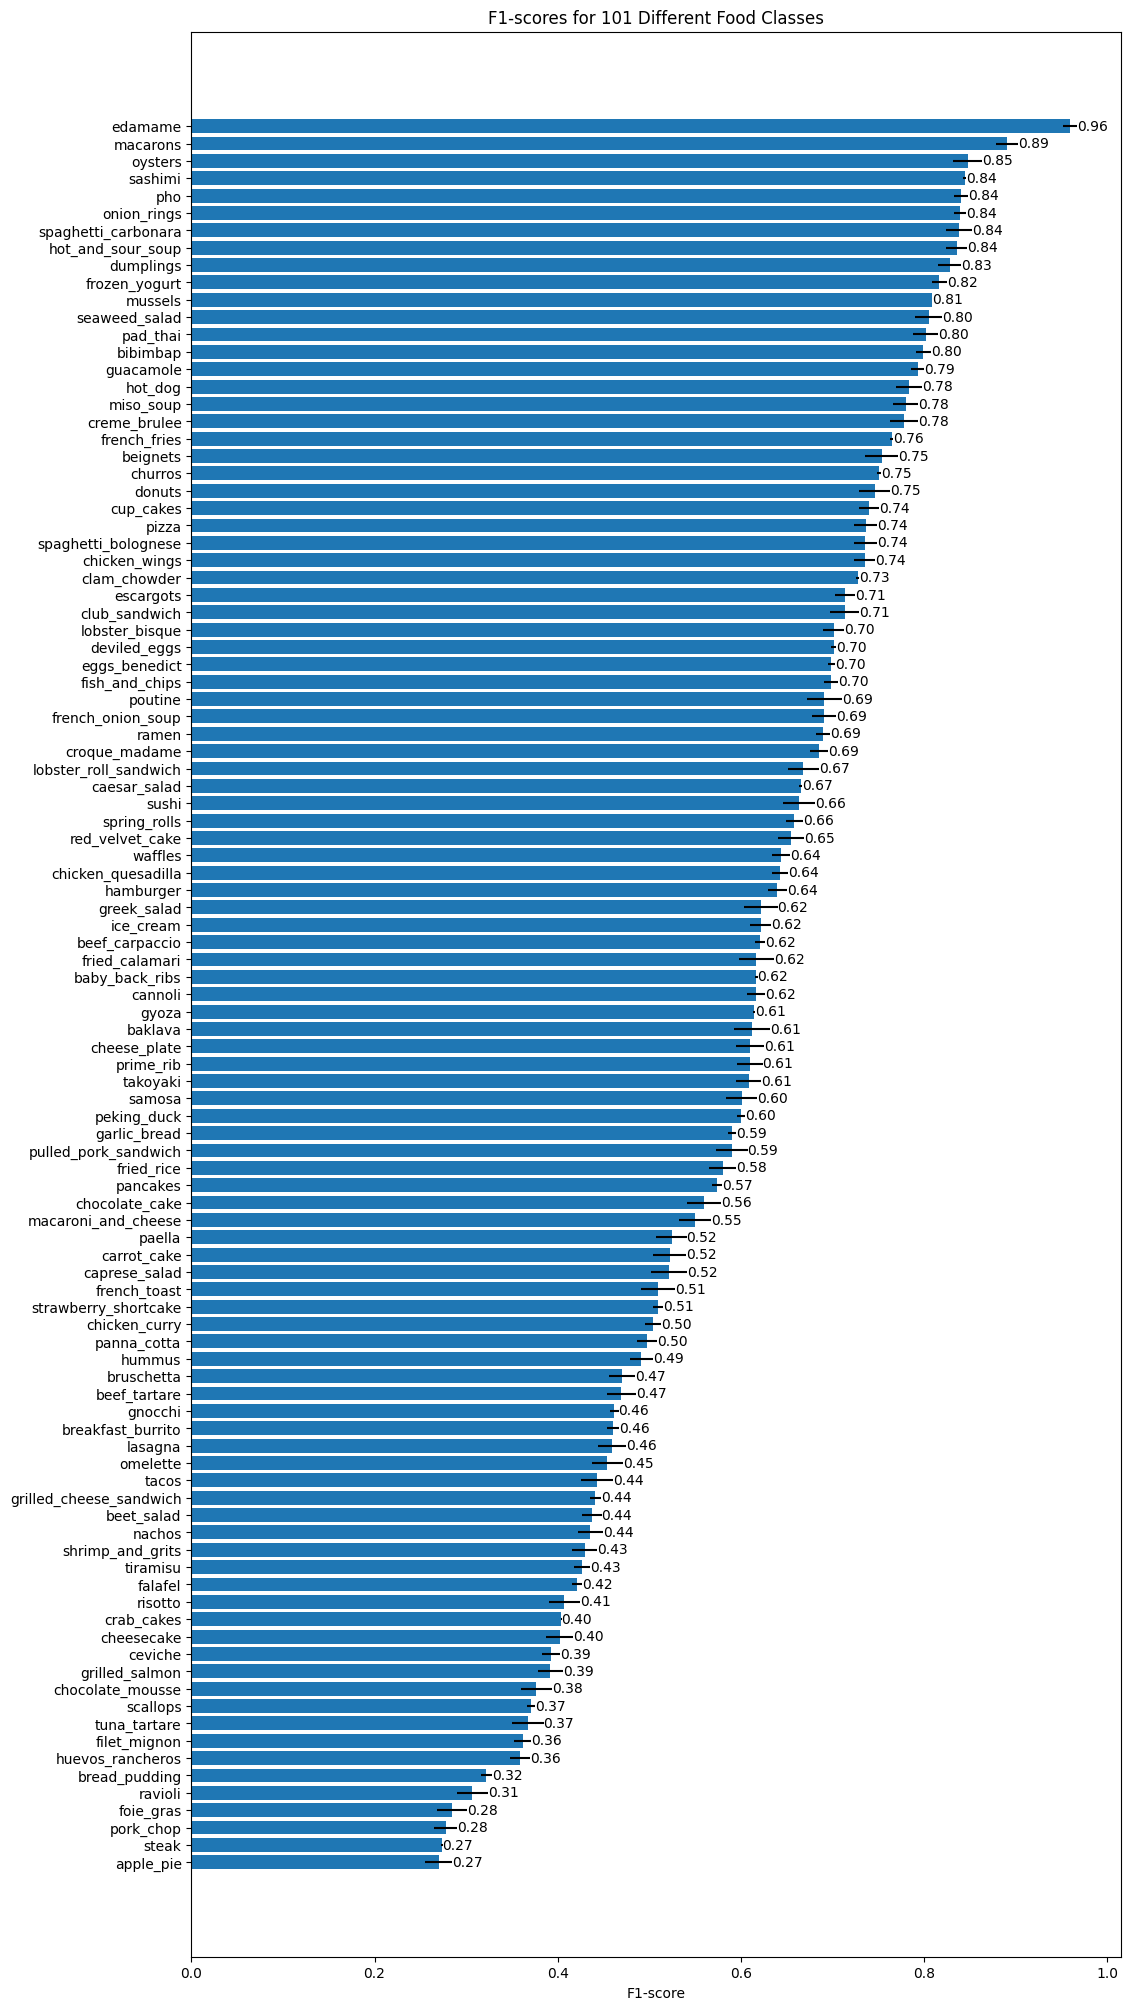

In [117]:
import matplotlib.pyplot as plt

error = np.random.uniform(high=0.02, size=len(df_f1_scores))
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(df_f1_scores)), df_f1_scores['f1-scores'], xerr=error)
ax.set_yticks(range(len(df_f1_scores)))
ax.set_yticklabels(df_f1_scores['class_names'])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis()
ax.bar_label(scores, fmt='%.2f');

In [118]:
def load_and_prep(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

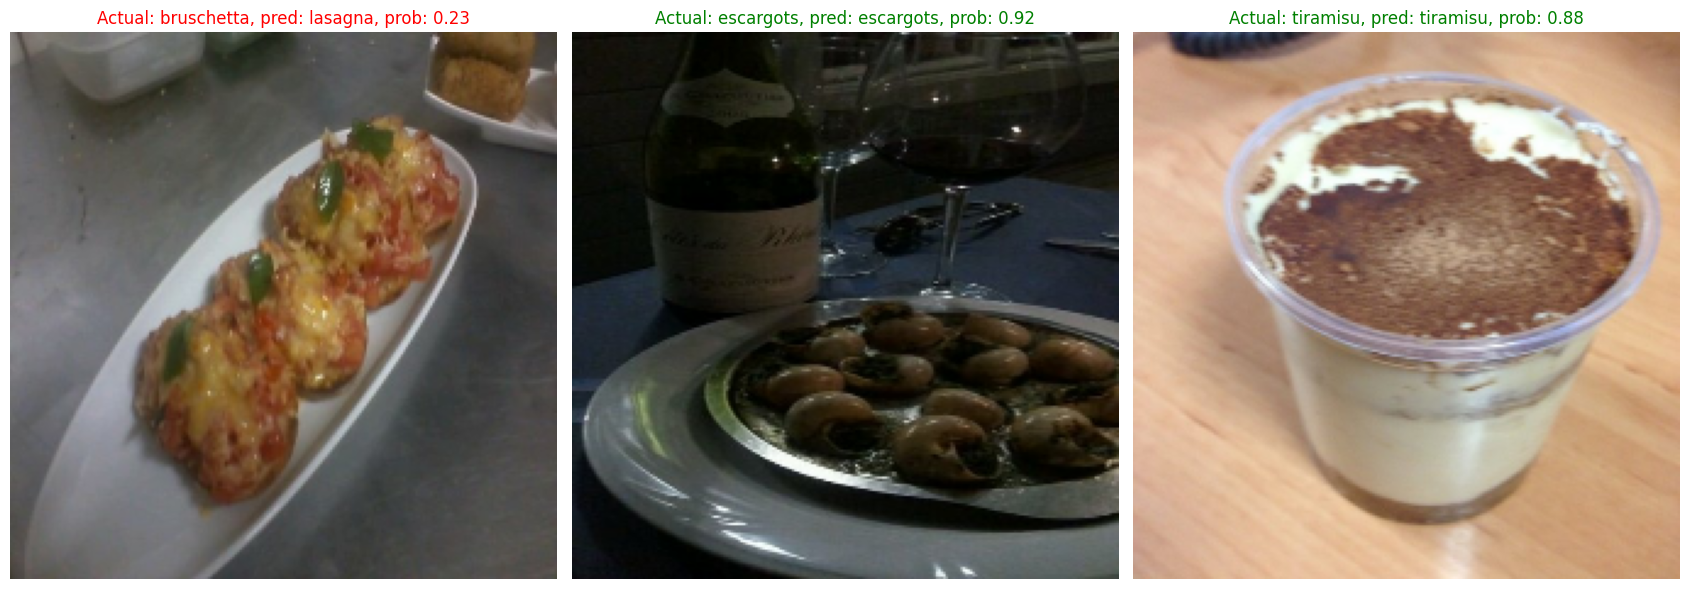

In [137]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + '/' + filename
  img = load_and_prep(filename=filepath, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0), verbose=0)
  pred_class = class_names[pred_prob.argmax()]

  #plotting
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis('off')
  plt.tight_layout()